In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,qgrid,rpy2,libpgm,pgmpy,networkx,graphviz,pybnl,pytest

cs224 
last updated: 2020-03-25 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
qgrid 1.3.0
rpy2 3.2.6
libpgm 1.3
pgmpy 0.1.10
networkx 2.4
graphviz 0.13.2
pybnl 0.1.0a1
pytest 5.4.1


Access other versions via nbviwer:
[https://nbviewer.jupyter.org/github/cs224/pybnl/blob/4bd08e6e48194dcddeadf0f202b910e3e224753b/examples/010-2018-06-15-marks.ipynb](https://nbviewer.jupyter.org/github/cs224/pybnl/blob/4bd08e6e48194dcddeadf0f202b910e3e224753b/examples/010-2018-06-15-marks.ipynb)

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
import sklearn, sklearn.pipeline
import networkx as nx, graphviz, networkx.algorithms.dag
import random

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext rpy2.ipython

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
%load_ext autoreload
%autoreload 1
%aimport pybnl.bn

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))


# IMPORTANT: dont' use rpy2.robjects.pandas2ri.activate()

This will break the functionality of the pybnl library

In [6]:
import locale
locale.setlocale(locale.LC_ALL, 'C')

import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
# rpy2.robjects.pandas2ri.activate()

In [7]:
rpackageversionfn = rpy2.robjects.r('packageVersion')
print(rpackageversionfn("bnlearn")[0])

[1] 4 5



In [8]:
# import rpy2.robjects as ro, rpy2.robjects.packages, rpy2.robjects.pandas2ri, rpy2.robjects.numpy2ri
# m = ro.r.matrix(ro.IntVector(range(10)), nrow=5)
# print(m)

# learning.test

Before we look at the `marks` data-set let's look first at a test network provided in the `bnlearn` package:
[networks](http://www.bnlearn.com/documentation/networks/)
<img src='http://www.bnlearn.com/documentation/networks/learning.test.png' width=400>

In [9]:
%%R -o rdf_lt
data(learning.test)
rdf_lt = learning.test

## Converting the R data.frame into a python pd.DataFrame and converting to CategoricalDtype

After loading the data-set we need to convert it so that all variables are of type `CategoricalDtype`: see the pandas documentation about [Categorical Data](https://pandas.pydata.org/pandas-docs/stable/categorical.html) for more details.

In [10]:
#df_lt = rpy2.robjects.pandas2ri.ri2py(rdf_lt)
df_lt = rdf_lt

ct1 = pd.api.types.CategoricalDtype(['a', 'b', 'c'], ordered=True)
ct2 = pd.api.types.CategoricalDtype(['a', 'b'], ordered=True)

for c in 'ABCDE':
    df_lt[c] = df_lt[c].astype(ct1)
df_lt['F'] = df_lt['F'].astype(ct2)

df_lt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   A       5000 non-null   category
 1   B       5000 non-null   category
 2   C       5000 non-null   category
 3   D       5000 non-null   category
 4   E       5000 non-null   category
 5   F       5000 non-null   category
dtypes: category(6)
memory usage: 69.0+ KB


## ConstraintBasedNetFromDataDiscreteBayesNetwork

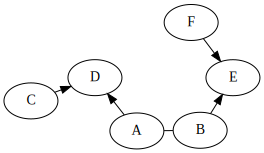

In [11]:
cbnet = pybnl.bn.ConstraintBasedNetFromDataDiscreteBayesNetwork(df_lt)
cbnet.fit()
#display_side_by_side(cbnet.structure().dot(),cbnet.structure().cpdag().dot())
cbnet.structure().cpdag().dot()

In [12]:
print(cbnet.rnet)


  Bayesian network learned via Constraint-based methods

  model:
   [B][C][F][A|B][E|B:F][D|A:C] 
  nodes:                                 6 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           2.33 
  average neighbourhood size:            1.67 
  average branching factor:              0.83 

  learning algorithm:                    Semi-Interleaved HITON-PC 
  conditional independence test:         Mutual Information (disc., MC) 
  alpha threshold:                       0.05 
  permutations:                          5000 
  tests used in the learning procedure:  63 




## ScoreBasedNetFromDataDiscreteBayesNetwork

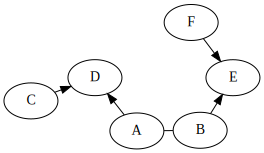

In [13]:
sbnet = pybnl.bn.ScoreBasedNetFromDataDiscreteBayesNetwork(df_lt)
sbnet.fit()
sbnet.structure().cpdag().dot()

## HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork

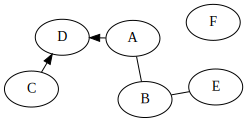

In [14]:
hnet1 = pybnl.bn.HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork(df_lt)
hnet1.fit()
hnet1.structure().cpdag().dot()

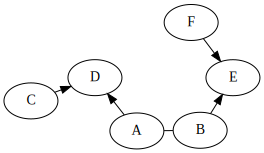

In [15]:
hnet2 = pybnl.bn.HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork(df_lt, algorithm='rxmax2_sihitonpc_tabu')
hnet2.fit()
hnet2.structure().cpdag().dot()

In [16]:
hnet2.structure().cpdag().vstructs()

,X,Z,Y
0,A,D,C
1,B,E,F


# marks

Let's take the detour of loading the `R` data set, writing it to CSV and then loading the CSV via pandas from python. Like that we're sure we have a typical starting position in a `python` data workflow.

In [17]:
%%R -o marks
library(bnlearn)
data(marks)
write.csv(marks, file = "marks.csv")

In [18]:
pd_marks = pd.read_csv('marks.csv', index_col=0).astype(np.float64)
pd_marks.head()

,MECH,VECT,ALG,ANL,STAT
1,77.0,82.0,67.0,67.0,81.0
2,63.0,78.0,80.0,70.0,81.0
3,75.0,73.0,71.0,66.0,81.0
4,55.0,72.0,63.0,70.0,68.0
5,63.0,63.0,65.0,70.0,63.0


In [19]:
hbt = pybnl.bn.HarteminkBinTransformer(3,ibreaks=18)
dmarks = hbt.fit_transform(X=pd_marks)

In [20]:
# dmarks = pybnl.bn.discretize(pd_marks)
dmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   MECH    88 non-null     category
 1   VECT    88 non-null     category
 2   ALG     88 non-null     category
 3   ANL     88 non-null     category
 4   STAT    88 non-null     category
dtypes: category(5)
memory usage: 1.1 KB


In [21]:
dmarks['MECH'].dtype

CategoricalDtype(categories=['(0,35.8]', '(35.8,49]', '(49,77]'], ordered=False)

In [22]:
dmarks.head()

,MECH,VECT,ALG,ANL,STAT
0,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]"
1,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]"
2,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]"
3,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]"
4,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]"


Let's also create immediately a marks data-frame that include one additional latent variable that we will need later:

In [23]:
ldmarks = dmarks.copy()
pybnl.bn.augment_df_with_latent_variable(ldmarks, 'LAT', 3)
print(pybnl.bn.levels_of_latent_variable(ldmarks,'LAT'))
ldmarks.head()

['l000', 'l001', 'l002']


,MECH,VECT,ALG,ANL,STAT,LAT
0,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",NaN
1,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",NaN
2,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",NaN
3,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",NaN
4,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",NaN


## NetAndDataDiscreteBayesNetwork

### Create network by hand

In [24]:
dg = nx.DiGraph()
# G.add_node(1)
dg.add_nodes_from(list(marks.columns))
dg.add_edges_from([
    ['STAT', 'ANL'],
    ['STAT', 'ALG'],
    ['ANL', 'ALG'],
    ['ALG', 'MECH'],
    ['ALG', 'VECT'],
    ['VECT', 'MECH'],
])

In [25]:
list(nx.connected_components(dg.to_undirected()))

[{'ALG', 'ANL', 'MECH', 'STAT', 'VECT'}]

In [26]:
ns = pybnl.bn.digraph2netstruct(dg)

You can display the graph either in the 'dot' format or in the default more compact 'fdp' format

In [27]:
type(ns.dot())

graphviz.dot.Digraph

In [28]:
display_graphs_side_by_side(ns.dot(engine='dot'), ns.dot())

"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.40.1 (20161225.0304) --> <!-- Title: %3 Pages: 1 --> %3 <!-- ALG --> ALG ALG <!-- MECH --> MECH MECH <!-- ALG->MECH --> ALG->MECH <!-- VECT --> VECT VECT <!-- ALG->VECT --> ALG->VECT <!-- ANL --> ANL ANL <!-- ANL->ALG --> ANL->ALG <!-- STAT --> STAT STAT <!-- STAT->ALG --> STAT->ALG <!-- STAT->ANL --> STAT->ANL <!-- VECT->MECH --> VECT->MECH"


### Fit the network

In [29]:
net_dmarks = pybnl.bn.NetAndDataDiscreteBayesNetwork(dmarks, rnet=ns.rnet)
net_dmarks.fit()
net_dmarks_net_and_data = net_dmarks
print(net_dmarks.rfit)


  Bayesian network parameters

  Parameters of node ALG (multinomial distribution)

Conditional probability table:
 
, , STAT = (9,25.5]

             ANL
ALG            (9,39.3] (39.3,62.3] (62.3,70]
  (15,48.8]   1.0000000   0.5000000          
  (48.8,58.7] 0.0000000   0.5000000          
  (58.7,80]   0.0000000   0.0000000          

, , STAT = (25.5,53.7]

             ANL
ALG            (9,39.3] (39.3,62.3] (62.3,70]
  (15,48.8]   0.7692308   0.2250000          
  (48.8,58.7] 0.2307692   0.6250000          
  (58.7,80]   0.0000000   0.1500000          

, , STAT = (53.7,81]

             ANL
ALG            (9,39.3] (39.3,62.3] (62.3,70]
  (15,48.8]   1.0000000   0.1111111 0.0000000
  (48.8,58.7] 0.0000000   0.4444444 0.0000000
  (58.7,80]   0.0000000   0.4444444 1.0000000


  Parameters of node ANL (multinomial distribution)

Conditional probability table:
 
             STAT
ANL            (9,25.5] (25.5,53.7] (53.7,81]
  (9,39.3]    0.7333333   0.2452830 0.0500000
  (39.3,62.3

## ConstraintBasedNetFromDataDiscreteBayesNetwork

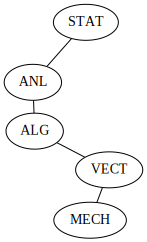

In [30]:
net_dmarks = pybnl.bn.ConstraintBasedNetFromDataDiscreteBayesNetwork(dmarks)
net_dmarks.fit()
net_dmarks_cb = net_dmarks
net_dmarks.structure().cpdag().dot()

## ScoreBasedNetFromDataDiscreteBayesNetwork

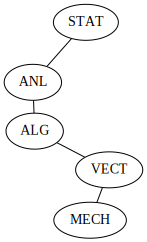

In [31]:
net_dmarks = pybnl.bn.ScoreBasedNetFromDataDiscreteBayesNetwork(dmarks)
net_dmarks.fit()
net_dmarks_sb = net_dmarks
net_dmarks.structure().cpdag().dot()

## HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork

### mmhc

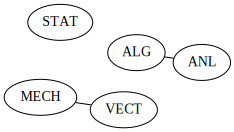

In [32]:
net_dmarks = pybnl.bn.HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork(dmarks)
net_dmarks.fit()
net_dmarks_hyb_mmhc = net_dmarks
net_dmarks.structure().cpdag().dot()

### rxmax2_sihitonpc_tabu

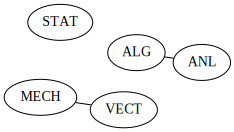

In [33]:
net_dmarks = pybnl.bn.HybridScoreAndConstainedBasedNetFromDataDiscreteBayesNetwork(dmarks, algorithm='rxmax2_sihitonpc_tabu')
net_dmarks.fit()
net_dmarks_hyb_rsmax = net_dmarks
net_dmarks.structure().cpdag().dot()

## Comparison

In [34]:
def score(type='bic'):
    cdf = pd.DataFrame(columns=['algorithm', 'score'])
    cdf.loc[len(cdf)] = ['ConstraintBased', net_dmarks_cb.score(type=type)]
    cdf.loc[len(cdf)] = ['ScoreBased', net_dmarks_sb.score(type=type)]
    cdf.loc[len(cdf)] = ['mmhc', net_dmarks_hyb_mmhc.score(type=type)]
    cdf.loc[len(cdf)] = ['rsmax', net_dmarks_hyb_rsmax.score(type=type)]
    return cdf

display_side_by_side(score(), score(type='loglik'))

,algorithm,score
0,ConstraintBased,-411.497387
1,ScoreBased,-411.497387
2,mmhc,-434.906936
3,rsmax,-434.906936
,algorithm,score
0,ConstraintBased,-353.292008
1,ScoreBased,-353.292008
2,mmhc,-394.610904
3,rsmax,-394.610904


In [35]:
net_dmarks_cb.structure().bf(net_dmarks_hyb_mmhc.structure(), dmarks)

23.332540436607594

In [36]:
net_dmarks_cb.bf(net_dmarks_hyb_mmhc, dmarks)

23.332540436607594

In [37]:
net_dmarks_cb.bf(net_dmarks_hyb_mmhc)

23.332540436607594

## sklearn pipeline

In [38]:
# import warnings
# warnings.simplefilter('error', FutureWarning)

In [39]:
pl = sklearn.pipeline.Pipeline(
    steps=[
        ('hartemink', pybnl.bn.HarteminkBinTransformer(3,ibreaks=18)),
        ('score', pybnl.bn.ScoreBasedNetFromDataDiscreteBayesNetwork()),
          ]
)
pl.set_params(hartemink__breaks=3).fit(pd_marks, None)

Pipeline(memory=None,
         steps=[('hartemink', HarteminkBinTransformer(breaks=3, ibreaks=18)),
                ('score',
                 ScoreBasedNetFromDataDiscreteBayesNetwork(algorithm='hc',
                                                           ldf=None,
                                                           predict_var=None,
                                                           whitelist=None))],
         verbose=False)

In [40]:
pl.score(dmarks)

-411.49738682714093

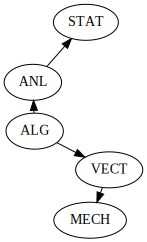

In [41]:
pl.steps[-1][1].structure().dot()

In [42]:
pl.set_params(hartemink__breaks=5).fit(pd_marks, None)
pl.score(dmarks)

-682.3887051571114

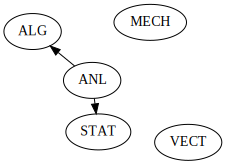

In [43]:
pl.steps[-1][1].structure().dot()

In [44]:
pl.set_params(hartemink__breaks=7).fit(pd_marks, None)
pl.score(dmarks)

-876.9315865210814

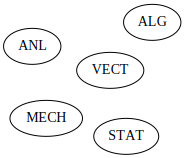

In [45]:
pl.steps[-1][1].structure().dot()

## StructuralEMNetFromDataDiscreteBayesNetwork

In [46]:
ldmarks.columns

Index(['MECH', 'VECT', 'ALG', 'ANL', 'STAT', 'LAT'], dtype='object')

identified latent variables: ['LAT']


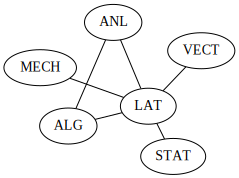

In [47]:
net_ldmarks = pybnl.bn.StructuralEMNetFromDataDiscreteBayesNetwork(ldmarks)
net_ldmarks.fit(ldmarks)
net_ldmarks.structure().cpdag().dot()

In [48]:
net_ldmarks.imputed_.head()

,MECH,VECT,ALG,ANL,STAT,LAT
0,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
1,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
2,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
3,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
4,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000


In [49]:
net_ldmarks.score()

-498.01212119623887

42580
identified latent variables: ['LAT']


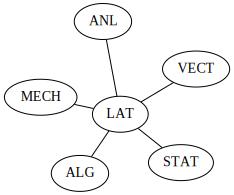

In [50]:
random.seed()
seed = random.randint(1,100000)
seed = 42580
print(seed)
net_ldmarks = pybnl.bn.StructuralEMNetFromDataDiscreteBayesNetwork(ldmarks)
net_ldmarks.fit(seed=seed)
net_ldmarks.structure().cpdag().dot()

In [51]:
net_ldmarks.imputed_.head()

,MECH,VECT,ALG,ANL,STAT,LAT
0,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
1,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
2,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
3,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000
4,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",l000


In [52]:
net_ldmarks.score()

-441.1892509611524

### Comparison to literature example

Let's compare this to the example values and network given in [Bayesian Networks in R](https://books.google.de/books?id=OCy5BAAAQBAJ&lpg=PP1&hl=de&pg=PP1#v=onepage&q&f=false) on page 45:

In [53]:
latent = pd.Series(['A']*44 + ['B'] + ['A']*7 + ['B']*36,name='latent')
latent = latent.astype(pd.api.types.CategoricalDtype(['A', 'B'], ordered=False))
latent.head()

0    A
1    A
2    A
3    A
4    A
Name: latent, dtype: category
Categories (2, object): [A, B]

In [54]:
d_marks_with_latent = dmarks.copy()
d_marks_with_latent['LAT'] = latent

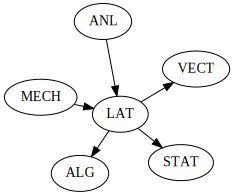

In [55]:
dg_marks_with_latent = nx.DiGraph()
# G.add_node(1)
dg_marks_with_latent.add_nodes_from(list(d_marks_with_latent.columns))
dg_marks_with_latent.add_edges_from([
    ['ANL', 'LAT'],
    ['MECH', 'LAT'],
    ['LAT', 'VECT'],
    ['LAT', 'STAT'],
    ['LAT', 'ALG'],
])
pybnl.bn.dot(dg_marks_with_latent.nodes(), list(dg_marks_with_latent.edges()), [])

First of all we note that the "correlation" between the given sequence and the one we reconstructed via `StructuralEMNetFromDataDiscreteBayesNetwork` is only "moderate":

In [56]:
pybnl.bn.relative_mutual_information(latent, net_ldmarks.imputed_['LAT'])

0.4585028017089931

Let's look at fitting the given network and data and see the score of this result:

In [57]:
d_marks_with_latent.head()

,MECH,VECT,ALG,ANL,STAT,LAT
0,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",A
1,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",A
2,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",A
3,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",A
4,"(49,77]","(60.7,82]","(58.7,80]","(62.3,70]","(53.7,81]",A


In [58]:
net_dmarks_with_latent = pybnl.bn.NetAndDataDiscreteBayesNetwork(d_marks_with_latent, dg=dg_marks_with_latent)
net_dmarks_with_latent.fit()
net_dmarks_with_latent.score()

-459.49059682403055

The score is slightly worse than the one we got above, e.g. our values we reconstructed via `StructuralEMNetFromDataDiscreteBayesNetwork` are a better fit. One important comment here: the example in the literature is not discretized, e.g. the values here are not one-to-one comparable.